# <font color='CornflowerBlue'>LULESH Jupyter Notebook</font>
Author(s) : Caleb Bean, Benjamin Hicks   
Purpose: Python code used to generate slurm job scripts, execute them, parse outputs, and plot meaningful data
## High level Job Execution Setup

In [14]:
# lulesh.ipynb
# Verified on Python 3.10.8
# Last date modified: 4/29/2024

import subprocess
import os
import matplotlib.pyplot as plt
import numpy as np


job_directory = '../LULESH/'
job_file_name = 'job-hw.sh'
job_path = job_directory+job_file_name

plot_directory = '../plots/'

email = 'caleb.bean@ufl.edu'

outfile_prefix = 'lulesh_out' # Note that currently outfiles do not get produced and the output is only available via stdout
errfile_prefix = 'lulesh_err'
slurmrun_cmd = 'srun ./lulesh2.0 -i 500 -s '

# Outputs we wish to track (MUST be printed stdout in form Foo=X where X is floating point data to be captured)
outputs_track = [
                'Time',
                'Cycles'
                ]

# outputs_dict used to store all parsed outputs (dont touch this)
outputs_dict = {}
for output in outputs_track:
    outputs_dict[output] = []

### Serial Execution Parameter Setup

In [15]:
# # SBATCH parameters
# # lulesh_s_param = [5,8]
# lulesh_s_param = [5,8,10,12,14,16,18,20,22,25,32,48]
# omp_num_threads = []
# nodes = [1]*len(lulesh_s_param)
# ntasks = [1]*len(lulesh_s_param)
# ntasks_per_node = [1]*len(lulesh_s_param)

# job_count = len(lulesh_s_param)

### OpenMP Execution Parameter Setup

In [16]:
# # SBATCH parameters
# # lulesh_s_param = [5,8]
# # lulesh_s_param = [5,8,10,12,14,16,18,20,22,25,32,48]
# omp_num_threads = [1,2,4,8,16,32]
# cpus_per_task = omp_num_threads
# lulesh_s_param = [81]*len(omp_num_threads)
# nodes = [1]*len(omp_num_threads)
# ntasks = [1]*len(omp_num_threads)
# ntasks_per_node = [1]*len(omp_num_threads)

# job_count = len(omp_num_threads)

### MPI Execution Parameter Setup

In [17]:
# # SBATCH parameters

# ntasks = [65]
# ntasks_per_node = ntasks
# # ntasks_per_node = [1]*len(ntasks)
# cpus_per_task = [1]*len(ntasks)
# nodes = []
# omp_num_threads = []
# lulesh_s_param = [80]*len(ntasks)

# job_count = len(ntasks)

### MPI+OMP Execution Parameter Setup

In [18]:
# SBATCH parameters

ntasks = [1,2,4,8,16,32,64]
ntasks_per_node = ntasks
# ntasks_per_node = [1]*len(ntasks)
cpus_per_task = [16]*len(ntasks)
nodes = [1]*len(ntasks)
omp_num_threads = cpus_per_task
lulesh_s_param = [32]*len(ntasks)

job_count = len(ntasks)

## Function and variable definitions

In [19]:
sbatch_cmds_dict = {
    '#!/bin/bash'                           : [],
    '#SBATCH --mail-type=FAIL'              : [],
    '#SBATCH --mail-user='+email            : [],
    '#SBATCH --account=eel6763'             : [],
    '#SBATCH --qos=eel6763'                 : [],
    '#SBATCH --nodes='                      : nodes, # Fill this
    '#SBATCH --ntasks='                     : ntasks, # Fill this
    '#SBATCH --ntasks-per-node='            : ntasks_per_node, # Fill this
    '#SBATCH --cpus-per-task='              : cpus_per_task,
    '#SBATCH --mem-per-cpu=500mb'           : [],
    '#SBATCH -t 00:20:00'                   : [],
    '#SBATCH -o '+outfile_prefix            : list(range(job_count)),
    '#SBATCH -e '+errfile_prefix            : list(range(job_count)),
    'export OMP_NUM_THREADS='               : omp_num_threads,
    slurmrun_cmd                            : lulesh_s_param, # Fill this
    }


def genSlurmCmds(sbatch_cmds_dict : dict, job_count : int):
    # This function converts the vectorized dictionary into individual string arrays to be written to slurm files
    
    slurm_cmds_arr = [[]]*job_count
    
    for i in range(job_count):
        cmd_str_arr = []
        for cmd in sbatch_cmds_dict:

            if(sbatch_cmds_dict[cmd]): cmd_str_arr.append(cmd+str(sbatch_cmds_dict[cmd][i]))
            else: cmd_str_arr.append(cmd)
            
        slurm_cmds_arr[i] = cmd_str_arr

    return slurm_cmds_arr

def genSlurmFile(cmds, path : str):
    with open (path, 'w+') as slurmf: 
        for cmd in cmds:
            slurmf.write(cmd + '\n')

    os.chmod(path, 0o744)


def executeSlurmFile(job_dir, job_name):
    
    slurm = subprocess.run(['./'+job_name], cwd=job_dir, stdout=subprocess.PIPE, encoding='utf-8') # Should return once complete I think
    slurm.check_returncode() # Ensures process ran and exited properly
    
    output_text = slurm.stdout
    #print(output_text)
    return output_text

def parseOutputText(text: str, out_dict: str):

    lines = text.splitlines()

    for key in out_dict:
        for line in lines:
            if key in line:
                temp = line.split(key)[1]
                temp = temp.replace('=','')
                out_dict[key].append(float(temp))
    
    #print(out_dict)


## Code build and execution of each job

In [20]:

slurm_cmds_arr = genSlurmCmds(sbatch_cmds_dict, job_count)

for slurm_cmds in slurm_cmds_arr:
    print(slurm_cmds)
    genSlurmFile(slurm_cmds, job_path)
    output_text = executeSlurmFile(job_directory, job_file_name)
    parseOutputText(output_text, outputs_dict)

['#!/bin/bash', '#SBATCH --mail-type=FAIL', '#SBATCH --mail-user=caleb.bean@ufl.edu', '#SBATCH --account=eel6763', '#SBATCH --qos=eel6763', '#SBATCH --nodes=1', '#SBATCH --ntasks=1', '#SBATCH --ntasks-per-node=1', '#SBATCH --cpus-per-task=16', '#SBATCH --mem-per-cpu=500mb', '#SBATCH -t 00:20:00', '#SBATCH -o lulesh_out0', '#SBATCH -e lulesh_err0', 'export OMP_NUM_THREADS=16', 'srun ./lulesh2.0 -i 500 -s 32']


srun: job 30403237 queued and waiting for resources
srun: job 30403237 has been allocated resources


['#!/bin/bash', '#SBATCH --mail-type=FAIL', '#SBATCH --mail-user=caleb.bean@ufl.edu', '#SBATCH --account=eel6763', '#SBATCH --qos=eel6763', '#SBATCH --nodes=1', '#SBATCH --ntasks=2', '#SBATCH --ntasks-per-node=2', '#SBATCH --cpus-per-task=16', '#SBATCH --mem-per-cpu=500mb', '#SBATCH -t 00:20:00', '#SBATCH -o lulesh_out1', '#SBATCH -e lulesh_err1', 'export OMP_NUM_THREADS=16', 'srun ./lulesh2.0 -i 500 -s 32']


srun: job 30403709 queued and waiting for resources
srun: job 30403709 has been allocated resources


['#!/bin/bash', '#SBATCH --mail-type=FAIL', '#SBATCH --mail-user=caleb.bean@ufl.edu', '#SBATCH --account=eel6763', '#SBATCH --qos=eel6763', '#SBATCH --nodes=1', '#SBATCH --ntasks=4', '#SBATCH --ntasks-per-node=4', '#SBATCH --cpus-per-task=16', '#SBATCH --mem-per-cpu=500mb', '#SBATCH -t 00:20:00', '#SBATCH -o lulesh_out2', '#SBATCH -e lulesh_err2', 'export OMP_NUM_THREADS=16', 'srun ./lulesh2.0 -i 500 -s 32']


srun: job 30404267 queued and waiting for resources
srun: job 30404267 has been allocated resources


['#!/bin/bash', '#SBATCH --mail-type=FAIL', '#SBATCH --mail-user=caleb.bean@ufl.edu', '#SBATCH --account=eel6763', '#SBATCH --qos=eel6763', '#SBATCH --nodes=1', '#SBATCH --ntasks=8', '#SBATCH --ntasks-per-node=8', '#SBATCH --cpus-per-task=16', '#SBATCH --mem-per-cpu=500mb', '#SBATCH -t 00:20:00', '#SBATCH -o lulesh_out3', '#SBATCH -e lulesh_err3', 'export OMP_NUM_THREADS=16', 'srun ./lulesh2.0 -i 500 -s 32']


srun: job 30404645 queued and waiting for resources
srun: job 30404645 has been allocated resources


['#!/bin/bash', '#SBATCH --mail-type=FAIL', '#SBATCH --mail-user=caleb.bean@ufl.edu', '#SBATCH --account=eel6763', '#SBATCH --qos=eel6763', '#SBATCH --nodes=1', '#SBATCH --ntasks=16', '#SBATCH --ntasks-per-node=16', '#SBATCH --cpus-per-task=16', '#SBATCH --mem-per-cpu=500mb', '#SBATCH -t 00:20:00', '#SBATCH -o lulesh_out4', '#SBATCH -e lulesh_err4', 'export OMP_NUM_THREADS=16', 'srun ./lulesh2.0 -i 500 -s 32']


srun: job 30405053 queued and waiting for resources
srun: job 30405053 has been allocated resources


## Test setup and plotting
### Start by printing the parsed outputs

In [ ]:
print(outputs_dict) 

{'Time': [270.0, 280.0, 280.0, 420.0, 390.0, 390.0, 390.0], 'Cycles': [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]}


### Serial Analysis Plotting Setup

In [ ]:
# figureName = "LULESH_seral"
# t = np.array(outputs_dict['Time'])
# iterations = np.array(outputs_dict['Cycles'])

# print("time/iteration: ", t/iterations)

# t_per_iter = (t/iterations)*1000

# fig, ax = plt.subplots()
# ax.plot(lulesh_s_param, t_per_iter)

# ax.set(xlabel='Problem size (length of cube mesh side)', ylabel='Time per iteration (in ms)',
#        title='LULESH OMP Analysis (4 threads)')
# ax.grid()

# fig.savefig(plot_directory+figureName+".png")

# plt.show()

### OpenMP Analysis Plotting Setup

In [ ]:
# figureName = "LULESH_OMP_81_final"
# t = np.array(outputs_dict['Time'])
# iterations = np.array(outputs_dict['Cycles'])

# print("time/iteration: ", t/iterations)

# t_per_iter = (t/iterations)*1000

# fig, ax = plt.subplots()
# ax.plot(omp_num_threads, t_per_iter)

# ax.set(xlabel='Number of threads', ylabel='Time per iteration (in ms)',
#        title='LULESH OMP Analysis (81 problem size, 500 iterations)')
# ax.grid()

# plt.xticks(omp_num_threads)

# fig.savefig(plot_directory+figureName+".png")

# plt.show()

### MPI Analysis Plotting Setup

In [ ]:

# figureName = "LULESH_MPI_30_nnnn"
# t = np.array(outputs_dict['Time'])
# iterations = np.array(outputs_dict['Cycles'])

# print("time/iteration: ", t/iterations)

# t_per_iter = (t/iterations)*1000

# fig, ax = plt.subplots()
# ax.plot(ntasks, t_per_iter)

# ax.set(xlabel='Number of cores', ylabel='Time per iteration (in ms)',
#        title='LULESH MPI Analysis (problem size = 50, iterations = 500)')
# ax.grid()
# plt.xticks(ntasks)
# fig.savefig(plot_directory+figureName+".png")

# plt.show()


### MPI+OMP Analysis Plotting Setup

time/iteration:  [0.54 0.56 0.56 0.84 0.78 0.78 0.78]


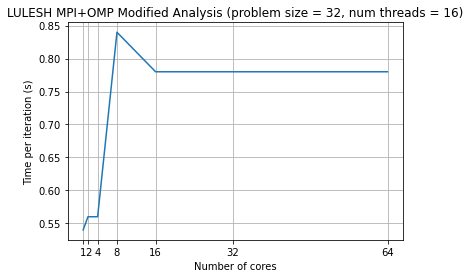

In [ ]:
figureName = "LULESH_updated_code_2"
t = np.array(outputs_dict['Time'])
iterations = np.array(outputs_dict['Cycles'])

print("time/iteration: ", t/iterations)

t_per_iter = (t/iterations)

fig, ax = plt.subplots()
ax.plot(ntasks, t_per_iter)

ax.set(xlabel='Number of cores', ylabel='Time per iteration (s)',
       title='LULESH MPI+OMP Modified Analysis (problem size = 32, num threads = 16)')
ax.grid()
plt.xticks(ntasks)
fig.savefig(plot_directory+figureName+".png")

plt.show()